# Impact Score

**COMPONENTES**:

**Sentiment Score**

*SentimentScoreExtractor(exclude_columns=None)*
- Análisis de sentimiento de las noticias con DISTILBERT.
- Devuelve un score de sentimiento por cada columna de texto que encuentra en el dataframe.
- El score va de -1 (negativo) a 1 (positivo).

**Category Impact**

*CategoryImpactExtractor(exclude_columns=None)*
- Impacto de cada temática en el histórico de los datos (ej.: noticias políticas - impacto alto, noticias deportivas - impacto bajo).
- Otorga un score ya fijado a una categoría.
- El score se ha obtenido previamente a través de una regresión lineal sobre el dataset original.
- El score va de -1 (muy poco impacto) a 1 (impacto elevado).

**NER Impact**

*NERScoreExtractor(exclude_columns=None, use_whitelist=True)*
- NER: Named Entity Recognition con la librería SpaCy.
- Si encuentra un nombre de entidad o persona en el texto, le otorga un score en función a su frecuencia de aparición y a su label.
- El peso de las label se obtiene a través de una regresión lineal sobre el dataset original.
- El score va de -1 (muy poco impacto) a 1 (impacto elevado).

**Novelty Score**

*NoveltyScoreExtractor(
    exclude_columns=None,
    window_size=30,
    max_features=1000,
    ngram_range=(1, 2),
    max_df=0.97,
    norm='l2',
)*
- Cuán diferente es una noticia comparada con los últimos días.
- Se utiliza la matriz tf-idf y el cosine-similarity
- Devuelve un score de -1 (no novedoso) a 1 (muy novedoso).


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from forecasting_bluesky_code import preprocessing as pre
from forecasting_bluesky_code import all_csv_directories as csv
from forecasting_bluesky_code import eda_plots as ep

In [259]:
# Definición de paleta para los plots
sns.set_theme()
sns.set_palette('husl')

In [261]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [263]:
df = pre.basic_proc_final_dataset(df)

In [265]:
df_weekly = pre.generate_weekly_df(df)

# Construcción de componentes

In [ ]:
# Para los objetos
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import pipeline
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

## Sentiment Score

In [12]:
# SENTIMENT SCORE FUNCTION

def get_sentiment_score(text, classifier):
    '''Helper function to compute sentiment score for a given text.
    Must receive a classifier object'''
    
    if isinstance(text, str) and text.strip() != '':
        result = classifier(text)
        label = result[0]['label']
        score = result[0]['score']
        return score if label == 'POSITIVE' else -score
    return 0 # 0 for empty strings

def sentiment_score(df, exclude_cols=None):
    '''Main function to add sentiment score columns. Receive a full dataframe and returns the df with new score columns.
    Only text columns.'''
    
    classifier = pipeline(
        task="text-classification",
        model="distilbert-base-uncased-finetuned-sst-2-english"
    )

    # Filter text columns
    text_df = df.drop(columns=exclude_cols) if exclude_cols else df.copy()

    # Prepare output DataFrame
    df_output = df.copy()

    for col in text_df.columns:
        new_col_name = f'{col}_sentiment_score'
        df_output[new_col_name] = text_df[col].apply(lambda x: get_sentiment_score(x, classifier))
        print(f'New column created: {new_col_name} from {col}')
    
    return df_output

In [13]:
class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    '''
    Calculates a Sentiment-Analysis-based score (-1 to 1) for each text field in the DataFrame.
    Uses DistilBERT for sentiment analysis.
    Score: -1: Negative, 0: Neutral, 1: Positive
    '''
    
    def __init__(self, exclude_columns=None):
        '''
        Exclude_columns = None by default
        
        Works with DistilBERT. 
        Documentation: https://huggingface.co/docs/transformers/model_doc/distilbert
        Model = "distilbert-base-uncased-finetuned-sst-2-english"
        '''
        self.exclude_columns = exclude_columns or []

    def fit(self, X, y=None):

        # Model run
        self.classifier = pipeline(
            task="text-classification",
            model="distilbert-base-uncased-finetuned-sst-2-english"
        )
        
        return self

    def transform(self, X):
        X_ = X.copy()

        # Columns Selection
        text_columns = [col for col in X_.columns if col not in self.exclude_columns]
        score_df = pd.DataFrame(index=X_.index)

        for col in text_columns:
            new_col_name = f'{col}_sentiment_score'
            score_df[new_col_name] = X_[col].apply(lambda x: self._get_sentiment_score(x))
        
        return score_df

    def _get_sentiment_score(self, text):
        if isinstance(text, str) and text.strip() != '':
            result = self.classifier(text)
            label = result[0]['label']
            score = result[0]['score']
            return score if label == 'POSITIVE' else -score
        return 0


In [14]:
sent_extractor = SentimentScoreExtractor()

In [15]:
sent_extractor

SentimentScoreExtractor(exclude_columns=[])

In [16]:
sent_extractor.get_params()

{'exclude_columns': []}

In [ ]:
sent_df = sent_extractor.fit_transform(df_text)

In [ ]:
sent_df

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(sent_df.T, cmap='coolwarm', center=0, cbar_kws={'label': 'Sentiment Score'})
plt.title('Evolución del Sentimiento por Categoría')
plt.xlabel('Fecha')
plt.ylabel('Categoría temática')
plt.tight_layout()
plt.show()

In [ ]:
mean_scores = sent_df.mean().sort_values(ascending=False)
mean_scores.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Sentimiento Promedio por Categoría')
plt.ylabel('Sentiment Score')
plt.xlabel('Categoría')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('mean_sentiment_topic.png')
plt.show()

## Category Impact

In [ ]:
# CATEGORY IMPACT FUNCTION

def category_impact_score(df, exclude_cols=None):
    '''
    Gives a score to every headline category based in past analysis.
    If the category is new, score = 0.
    Receive a full dataframe and returns the df with new score columns.
    '''
    
    category_weights = {'artificial intelligence': -0.33,
                        'crime': 0.1,
                        'education': -0.8,
                        'elections': 1.0,
                        'entertainment': -0.22,
                        'environment': -0.44,
                        'finance': 0.52,
                        'health': 0.62,
                        'immigration': -0.8,
                        'international relations': -0.47,
                        'pandemics': -0.49,
                        'politics': 0.06,
                        'protests': -0.35,
                        'science': -0.38,
                        'sports': -0.81,
                        'technology': -0.38,
                        'videogames': -1.0,
                        'war': 0.04}

    # Filter text columns
    text_df = df.drop(columns=exclude_cols) if exclude_cols else df.copy()

    # Prepare output DataFrame
    df_output = df.copy()

    for col in text_df.columns:
        new_col_name = f'{col}_category_score'
        if col in category_weights.keys():
            df_output[new_col_name] = category_weights[col]
            print(f'New column created: {new_col_name} from {col}')
        else:
            df_output[new_col_name] = 0
    
    return df_output

    

In [ ]:
class CategoryImpactExtractor(BaseEstimator, TransformerMixin):
    '''
    Calculates a Category-based score (-1 to 1) for each text field in the DataFrame.
    Uses predefined category weights.
    If the category is new, score = 0.
    '''
    def __init__(self, exclude_columns=None):
        '''
        Exclude_columns = None by default
        
        Check out category weights with .category_weights
        '''
        self.exclude_columns = exclude_columns or []

        # Category Weights
        self.category_weights = {
            'artificial intelligence': -0.33,
            'crime': 0.1,
            'education': -0.8,
            'elections': 1.0,
            'entertainment': -0.22,
            'environment': -0.44,
            'finance': 0.52,
            'health': 0.62,
            'immigration': -0.8,
            'international relations': -0.47,
            'pandemics': -0.49,
            'politics': 0.06,
            'protests': -0.35,
            'science': -0.38,
            'sports': -0.81,
            'technology': -0.38,
            'videogames': -1.0,
            'war': 0.04
        }

    def fit(self, X, y=None):
        # Nothing to learn
        return self

    def transform(self, X):
        X_ = X.copy()

        # Columns selection (all if not excluded)
        text_columns = [col for col in X_.columns if col not in self.exclude_columns]
        score_df = pd.DataFrame(index=X_.index)

        for col in text_columns:
            score = self.category_weights.get(col, 0)
            score_col_name = f'{col}_category_score'
            score_df[score_col_name] = score

        return score_df

In [ ]:
extractor = CategoryImpactExtractor()

In [ ]:
extractor

In [ ]:
extractor.category_weights

In [ ]:
category_scores = extractor.fit_transform(df_text)

## NER Score

In [ ]:
# NER SCORE FUNCTION
def ner_score(text, use_whitelist=False):
    """
    Calculates a NER-based score from a given text using entity type weights.
    If `use_whitelist=True`, entities in the whitelist are counted +0.5.
    """
    if not isinstance(text, str) or not text.strip():
        return 0

    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    whitelist = {'trump', 'elon musk', 'elon', 'musk', 'biden', 'putin', 'zelensky', 'xi', 'jinping', 'macron', 'von der leyen',
             'modi', 'meloni', 'lula da silva', 'netanyahu', 'kamala harris', 'le pen', 'milei', 'scholz',
             'twitter', 'x', 'tesla', 'united nations', 'european union', 'nato', 'us'}

    entity_weights = {'CARDINAL': -0.69,
                 'DATE': -0.64,
                 'EVENT': -0.93,
                 'FAC': -0.8,
                 'GPE': -0.73,
                 'LAW': -0.56,
                 'LOC': -0.77,
                 'MONEY': -0.31,
                 'NORP': -0.7,
                 'ORDINAL': -0.66,
                 'ORG': -0.69,
                 'PERSON': -0.68,
                 'PRODUCT': -1.0,
                 'QUANTITY': 1.0,
                 'TIME': -0.78,
                 'WORK_OF_ART': -0.95}
    
    doc = nlp(text)
    score = 0

    for ent in doc.ents:
        label = ent.label_
        if label in entity_weights:
            entity_clean = ent.text.lower().strip()
            print(entity_clean)

            if use_whitelist == True:
                if entity_clean in whitelist:
                    score += entity_weights[label] + 0.5
            else:
                score += entity_weights[label]

    return score

In [ ]:
class NERScoreExtractor(BaseEstimator, TransformerMixin):
    '''
    Calculates a NER-based score (-1 to 1) for each text field in the DataFrame.
    Uses SpaCy and predefined entity weights.
    '''

    def __init__(self, exclude_columns=None, use_whitelist=True):
        '''
        exclude_columns = None by default
        use_whitelist = if True, entities in the whitelist are counted +0.5
        
        Works with SpaCy. 
        Documentation: https://spacy.io/
        Model = en_core_web_sm"
        
        Check out entity weights with .category_weights
        Check out whitelist with .whitelist
        '''
        
        self.exclude_columns = exclude_columns or []
        self.use_whitelist = use_whitelist

        self.entity_weights = {
            'CARDINAL': -0.69, 'DATE': -0.64, 'EVENT': -0.93, 'FAC': -0.8,
            'GPE': -0.73, 'LAW': -0.56, 'LOC': -0.77, 'MONEY': -0.31,
            'NORP': -0.7, 'ORDINAL': -0.66, 'ORG': -0.69, 'PERSON': -0.68,
            'PRODUCT': -1.0, 'QUANTITY': 1.0, 'TIME': -0.78, 'WORK_OF_ART': -0.95
        }

        self.whitelist = {
            'trump', 'elon musk', 'elon', 'musk', 'biden', 'putin', 'zelensky', 'xi', 'jinping',
            'macron', 'von der leyen', 'modi', 'meloni', 'lula da silva', 'netanyahu',
            'kamala harris', 'le pen', 'milei', 'scholz', 'twitter', 'x', 'tesla',
            'united nations', 'european union', 'nato', 'us'
        }

    def fit(self, X, y=None):
        self.nlp = spacy.load("en_core_web_sm")
        return self

    def _score_text(self, text):
        if not isinstance(text, str) or text.strip() == "":
            return 0

        doc = self.nlp(text)
        score = 0

        for ent in doc.ents:
            label = ent.label_
            if label in self.entity_weights:
                weight = self.entity_weights[label]
                ent_text = ent.text.lower().strip()

                if self.use_whitelist:
                    if ent_text in self.whitelist:
                        weight += 0.5  # boost for whitelisted entities
                    else:
                        continue  # skip entities not in whitelist

                score += weight
        return score

    def transform(self, X):
        X_ = X.copy()
        text_columns = [col for col in X_.columns if col not in self.exclude_columns]
        score_df = pd.DataFrame(index=X_.index)

        for col in text_columns:
            new_col = f'{col}_ner_score'
            score_df[new_col] = X_[col].apply(self._score_text)

        return score_df


In [ ]:
ner_extractor = NERScoreExtractor()

In [ ]:
ner_extractor

In [ ]:
ner_df = ner_extractor.fit_transform(df_text)

## Novelty Score

In [ ]:
# NOVELTY SCORE FUNCTION

def tfidf_matrix(df, max_features=1000, ngram_range=(1,2), max_df=0.97, norm='l2'):
    '''Receives full dataframe (must have date column) and some optionals params.
    Preprocess and applies TF-IDF to all text columns in dataframe.
    Returns tfidf matrix'''

    df = df.reset_index(drop=False)
    
    # We save the 'date' column as Series for future reference
    date_col = df['date']
    
    # Numeric & Categoric
    num_ft = df._get_numeric_data().columns
    cat_ft = df.drop(columns=list(num_ft)+['date']).columns
    
    # Basic text cleaning (spaces, punctuation and NaN)
    for column in cat_ft:
        df[column] = df[column].apply(pre.text_cleaning)
        
    # Text join
    df['full_text'] = df[cat_ft].agg(" ".join, axis=1)
    
    # Pipeline
    vectorizer = Pipeline([
        ('bow', CountVectorizer(lowercase=True, max_features=max_features, stop_words='english', ngram_range=ngram_range, max_df=max_df)), # Bag-of-Words
        ('tfidf', TfidfTransformer(norm=norm)) # TF-IDF
    ])
    
    tfidf = vectorizer.fit_transform(df['full_text'])

    return tfidf
    
def compute_novelty_scores(tfidf_matrix, window_size=30):
    """
    Calculates a novelty score for each document based on cosine similarity
    to the rolling average of previous documents' TF-IDF vectors.
    
    tfidf_matrix: sparse matrix (e.g., from TfidfVectorizer)
    window_size: how many previous samples to average for comparison
    """

    tfidf_matrix = tfidf_matrix.toarray()
    
    novelty_scores = []

    for i in range(tfidf_matrix.shape[0]):
        if i < window_size:
            novelty_scores.append(0)  # not enough history
        else:
            current_vector = tfidf_matrix[i]
            previous_window = tfidf_matrix[i - window_size:i]
            mean_vector = previous_window.mean(axis=0)

            if current_vector.ndim == 1:
                current_vector = current_vector.reshape(1, -1)
            if mean_vector.ndim == 1:
                mean_vector = mean_vector.reshape(1, -1)
                
            similarity = cosine_similarity(current_vector, mean_vector)[0][0]
            novelty = 1 - similarity
            novelty_scores.append(novelty)

    return novelty_scores

In [ ]:
class NoveltyScoreExtractor(BaseEstimator, TransformerMixin):
    '''
    Calculates a cosine-similarity-based score (-1 to 1) for each row combined.
    Uses CountVectorizer, TfidfTransformer and cosine_similarity.
    '''

    def __init__(self, exclude_columns=None, window_size=30, max_features=1000, ngram_range=(1,2), max_df=0.97, norm='l2'):
        '''
        exclude_columns = None by default
        window_size = how many previous samples to average for comparison, 30 by default
        CountVectorizer params by default = max_features=1000, ngram_range=(1,2), max_df=0.97
        TfidfTransformer params by default = norm='l2'
        
        Works with Sklearn. 
        Documentation: https://scikit-learn.org/
        '''
        
        self.exclude_columns = exclude_columns or []
        self.window_size = window_size
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.norm = norm

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(lowercase=True, max_features=self.max_features, stop_words='english', ngram_range=self.ngram_range, max_df=self.max_df)
        self.tfidf = TfidfTransformer(norm=self.norm)
        return self

    def transform(self, X):
        X_ = X.copy()
        
        # Columns selection
        text_columns = [col for col in X_.columns if col not in self.exclude_columns]

        # Text row-combining 
        X_['full_text'] = X_[text_columns].fillna('').agg(' '.join, axis=1)

        bow = self.vectorizer.fit_transform(X_['full_text'])
        tfidf_matrix = self.tfidf.fit_transform(bow).toarray()

        # Calculate Novelty Score
        novelty_scores = []

        for i in range(tfidf_matrix.shape[0]):
            if i < self.window_size:
                novelty_scores.append(0)  # No history
            else:
                current_vector = tfidf_matrix[i].reshape(1, -1)
                window_vectors = tfidf_matrix[i - self.window_size:i]
                mean_vector = window_vectors.mean(axis=0).reshape(1, -1)

                similarity = cosine_similarity(current_vector, mean_vector)[0][0]
                novelty = 1 - similarity
                novelty_scores.append(novelty)

        # 0 filling first rows
        novelty_scores = [0] * (self.window_size) + novelty_scores[self.window_size:]
        
        return pd.DataFrame({'novelty_score': novelty_scores}, index=X_.index)

In [ ]:
nov_extractor = NoveltyScoreExtractor()

In [ ]:
nov_extractor

In [ ]:
nov_df = nov_extractor.fit_transform(df_text)

In [ ]:
nov_df

In [ ]:
ep.var_per_day(nov_df['novelty_score'], 'Novelty Score', save=True, filename='Novelty Score')

# Pipeline

In [30]:
from forecasting_bluesky.impact_score import SentimentScoreExtractor, CategoryImpactExtractor, NERScoreExtractor, NoveltyScoreExtractor
from sklearn.pipeline import Pipeline, FeatureUnion


In [32]:
# Unimos los 4 componentes en un único pipeline

impact_score_pipeline = FeatureUnion([
    ('sentiment', 
     SentimentScoreExtractor()),
    ('category', 
     CategoryImpactExtractor()),
    ('ner', 
     NERScoreExtractor()),
    ('novelty', 
     NoveltyScoreExtractor())
])


### Datos para el modelo
- X = matriz obtenida del impact_score_pipeline con los score de cada componente individual.
- y = clasificación binaria, 1 (hay pico de actividad) y 0 (no hay pico de actividad)

In [271]:
# Creamos la columna que será la target para el impact_score (daily)

# Porcentaje de crecimiento de la actividad
df = pre.activity_score_pca(df)
df['activity_growth_percentage'] = df['activity_score_pca'].pct_change() * 100
df['activity_growth_percentage'] = df['activity_growth_percentage'].fillna(0)

df_weekly = pre.activity_score_pca(df_weekly)
df_weekly['activity_growth_percentage'] = df_weekly['activity_score_pca'].pct_change() * 100
df_weekly['activity_growth_percentage'] = df_weekly['activity_growth_percentage'].fillna(0)

In [273]:
df.describe()

,tot_users,new_users,activity_score_pca,activity_growth_percentage
count,7.010000e+02,7.010000e+02,701.000000,701.000000
mean,9.325658e+06,4.917347e+04,0.000000,-6.729808
std,1.054796e+07,1.077515e+05,2.142227,155.693905
min,3.152200e+04,0.000000e+00,-1.725821,-3739.994787
25%,1.789001e+06,6.923476e+03,-1.277605,-1.763255
50%,5.586096e+06,1.455950e+04,-1.134542,0.004092
75%,1.124966e+07,4.679100e+04,0.786780,1.713578
max,3.450212e+07,1.014757e+06,8.717566,1145.383310


In [275]:
df_weekly.describe()

,tot_users,new_users,activity_score_pca,activity_growth_percentage
count,1.010000e+02,1.010000e+02,1.010000e+02,101.000000
mean,9.683269e+06,3.411242e+05,2.638154e-17,-8.515248
std,1.090816e+07,6.532057e+05,2.165758e+00,97.030657
min,4.857800e+04,0.000000e+00,-1.721089e+00,-804.737874
25%,1.879556e+06,5.889335e+04,-1.303349e+00,-6.299352
50%,5.606840e+06,1.019165e+05,-1.171124e+00,0.000000
75%,1.195171e+07,3.396960e+05,1.093075e+00,2.668641
max,3.450212e+07,4.071047e+06,7.556809e+00,366.422920


**Threshold**
- Para el daily, utilizamos el percentil 97% como threshold para los picos de crecimiento.
- Para el weekly, utilizamos el percentil de 90%, tratamos de mantener una coherencia entre ambos datasets.
- Por encima será 1, por debajo será 0. 

In [277]:
# Definimos el threshold para el dataset diario

threshold = df['activity_growth_percentage'].quantile(0.93)
print('threshold', threshold)

# Creamos la nueva columna target binaria
df['has_activity_peak'] = (df['activity_growth_percentage'] > threshold).astype(int)

threshold 10.878291705690257


In [ ]:

# X = matriz de scores de comportamiento
X = impact_score_pipeline.fit_transform(X_news)

# y = pico de actividad (0 no hay pico, 1 sí hay pico)
threshold = df['activity_growth_percentage'].quantile(0.93)
df['has_activity_peak'] = (df['activity_growth_percentage'] 
                           > threshold).astype(int)


In [279]:
# Evaluamos distribución
print(df.has_activity_peak.value_counts())
print('Porcentaje de 1: ', 56/645)

has_activity_peak
0    652
1     49
Name: count, dtype: int64
Porcentaje de 1:  0.08682170542635659


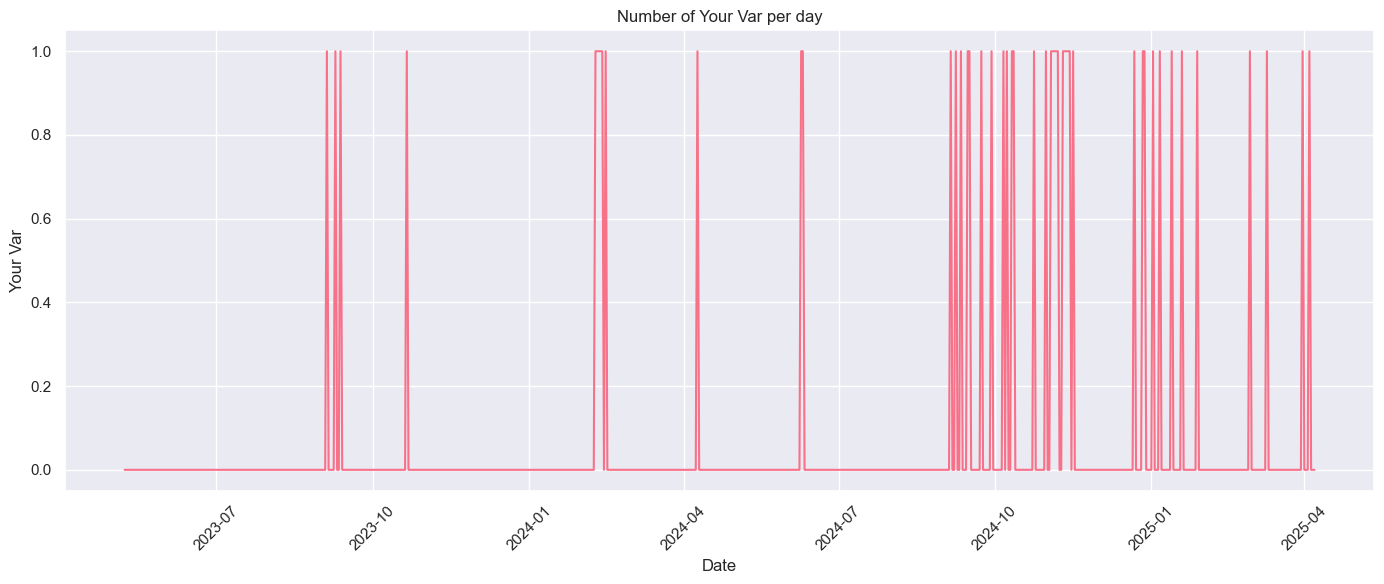

In [281]:
ep.var_per_day(df['has_activity_peak'])

In [295]:
# Definimos el threshold para el dataset semanal

threshold = df_weekly['activity_growth_percentage'].quantile(0.87)
print('threshold', threshold)

# Creamos la nueva columna target binaria
df_weekly['has_activity_peak'] = (df_weekly['activity_growth_percentage'] > threshold).astype(int)

threshold 8.072892525405063


In [299]:
# Evaluamos distribución
print(df_weekly.has_activity_peak.value_counts())
print('Porcentaje de 1: ', 13/88)

has_activity_peak
0    88
1    13
Name: count, dtype: int64
Porcentaje de 1:  0.14772727272727273


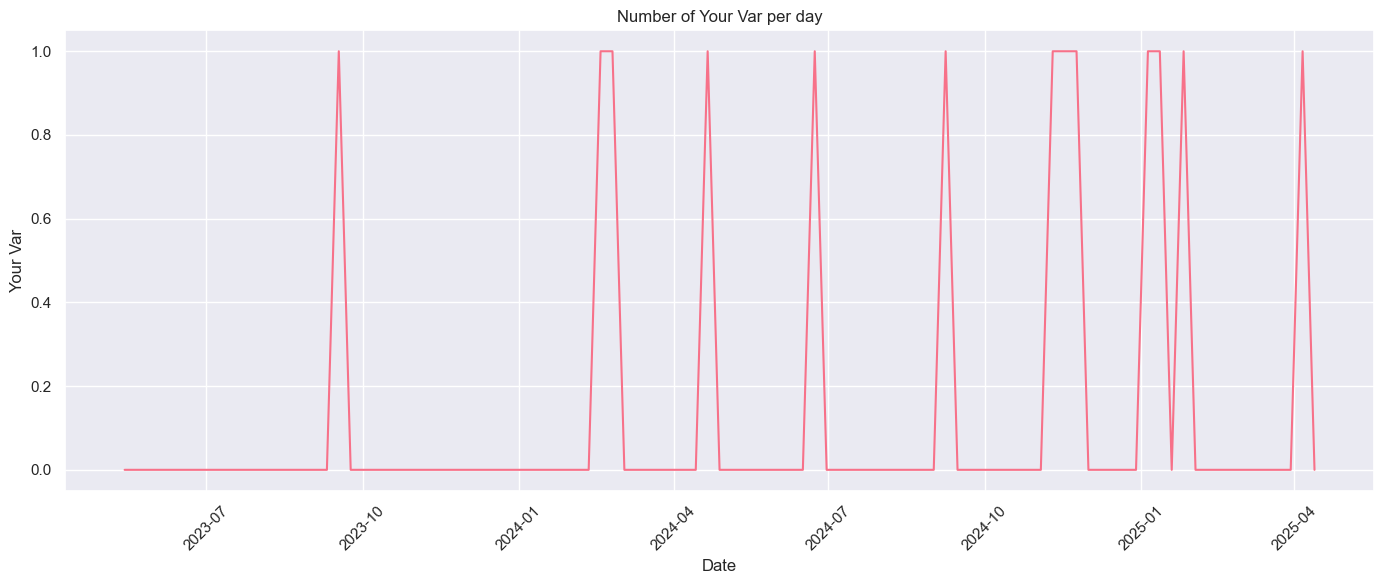

In [301]:
ep.var_per_day(df_weekly['has_activity_peak'])

**Dataframe de solo texto**

In [303]:
# Separamos los datos de texto (daily)
df_text = df.drop(columns = df._get_numeric_data().columns)

In [305]:
# Separamos los datos de texto (weekly)
df_text_weekly = df_weekly.drop(columns = df_weekly._get_numeric_data().columns)

**Train-Test Split**, manteniendo la línea temporal

In [308]:
### DAILY
# Preparamos los datos del train: registros de 2023 y 2024 completos
X_train = df_text.loc['2023-05-08':'2024-12-31',:]
y_train = df.loc['2023-05-08':'2024-12-31','has_activity_peak']

# Preparamos los datos que generarán el score, de 2025
X_test = df_text.loc['2025-01-01':,:]
y_test = df.loc['2025-01-01':,'has_activity_peak']

In [310]:
### WEEKLY
# Preparamos los datos del train: registros de 2023 y 2024 completos
X_train_weekly = df_text_weekly.loc['2023-05-08':'2024-12-31',:]
y_train_weekly = df_weekly.loc['2023-05-08':'2024-12-31','has_activity_peak']

# Preparamos los datos que generarán el score, de 2025
X_test_weekly = df_text_weekly.loc['2025-01-01':,:]
y_test_weekly = df_weekly.loc['2025-01-01':,'has_activity_peak']

In [312]:
X_test_weekly.index

DatetimeIndex(['2025-01-05', '2025-01-12', '2025-01-19', '2025-01-26',
               '2025-02-02', '2025-02-09', '2025-02-16', '2025-02-23',
               '2025-03-02', '2025-03-09', '2025-03-16', '2025-03-23',
               '2025-03-30', '2025-04-06', '2025-04-13'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

In [222]:
### DAILY
# Transformamos los datos de train con el pipeline
X_train_is = impact_score_pipeline.fit_transform(X_train)

Device set to use cpu


In [223]:
X_test_is = impact_score_pipeline.fit_transform(X_test)

Device set to use cpu


In [314]:
### WEEKLY
# Transformamos los datos de train con el pipeline
X_train_is_weekly = impact_score_pipeline.fit_transform(X_train_weekly)

Device set to use cpu


In [315]:
X_test_is_weekly = impact_score_pipeline.fit_transform(X_test_weekly)

Device set to use cpu


In [226]:
# Código para comprobar las salidas de todos los componentes
for name, transformer in impact_score_pipeline.transformer_list:
    print(f"Running: {name}")
    output = transformer.fit_transform(X_test_weekly)
    print(f"{name} output shape: {output.shape}")

Running: sentiment


Device set to use cpu


sentiment output shape: (15, 18)
Running: category
category output shape: (15, 18)
Running: ner
ner output shape: (15, 18)
Running: novelty
novelty output shape: (15, 1)


In [227]:
#Comprobamos que el resultado es correcto y no tiene errores (daily)
print('type: ', type(X_train_is), type(X_test_is))
print('shape: ', X_train_is.shape, X_test_is.shape)
print('NaN o Infinitos: ', np.any(np.isnan(X_train_is)), np.any(np.isinf(X_train_is)))
print('NaN o Infinitos: ', np.any(np.isnan(X_test_is)), np.any(np.isinf(X_test_is)))

type:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape:  (604, 55) (97, 55)
NaN o Infinitos:  False False
NaN o Infinitos:  False False


In [316]:
#Comprobamos que el resultado es correcto y no tiene errores (weekly)
print('type: ', type(X_train_is_weekly), type(X_test_is_weekly))
print('shape: ', X_train_is_weekly.shape, X_test_is_weekly.shape)
print('NaN o Infinitos: ', np.any(np.isnan(X_train_is_weekly)), np.any(np.isinf(X_train_is_weekly)))
print('NaN o Infinitos: ', np.any(np.isnan(X_test_is_weekly)), np.any(np.isinf(X_test_is_weekly)))

type:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape:  (86, 55) (15, 55)
NaN o Infinitos:  False False
NaN o Infinitos:  False False
